In [1]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain-core langchain-openai langchain-experimental langchain-community langchain chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25

# Install compatible versions of langchain libraries
%pip install langchain-core==0.3.6
%pip install langchain-openai==0.2.1
%pip install langchain-experimental==0.3.2
%pip install langchain-community==0.3.1
%pip install langchain==0.3.1

# Install remaining packages
%pip install chromadb==0.5.11
%pip install beautifulsoup4==4.12.3
%pip install python-dotenv==1.0.1
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2

# new packages to download for this code lab!
%pip install "unstructured[pdf]"
%pip install pillow==10.4.0
%pip install pydantic==2.9.2
%pip install lxml==5.3.0
%pip install matplotlib==3.9.2
%pip install tiktoken==0.7.0


Note: you may need to restart the kernel to use updated packages.
Found existing installation: langchain-core 0.3.28
Uninstalling langchain-core-0.3.28:
  Successfully uninstalled langchain-core-0.3.28
Found existing installation: langchain-openai 0.2.1
Uninstalling langchain-openai-0.2.1:
  Successfully uninstalled langchain-openai-0.2.1
Found existing installation: langchain-experimental 0.3.2
Uninstalling langchain-experimental-0.3.2:
  Successfully uninstalled langchain-experimental-0.3.2
Found existing installation: langchain-community 0.3.1
Uninstalling langchain-community-0.3.1:
  Successfully uninstalled langchain-community-0.3.1
Found existing installation: langchain 0.3.1
Uninstalling langchain-0.3.1:
  Successfully uninstalled langchain-0.3.1
Found existing installation: chromadb 0.5.11
Uninstalling chromadb-0.5.11:
  Successfully uninstalled chromadb-0.5.11
Found existing installation: beautifulsoup4 4.12.3
Uninstalling beautifulsoup4-4.12.3:
  Successfully uninstalled beau

In [1]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document

# new
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_core.runnables import RunnableLambda
from langchain.storage import InMemoryStore
from langchain_core.messages import HumanMessage
import base64
import uuid
from IPython.display import HTML, display
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
embedding_function = OpenAIEmbeddings()
short_pdf_path = "google-2023-environmental-report.pdf"
str_output_parser = StrOutputParser()

In [5]:
pdfloader = UnstructuredPDFLoader(
    short_pdf_path,
    mode="elements",
    strategy="hi_res",
    extract_image_block_types=["Image","Table"],
    extract_image_block_to_payload=True, # converts images to base64 format
)

pdf_data = pdfloader.load()

In [6]:
texts = [doc for doc in pdf_data if doc.metadata["category"] == "NarrativeText"]
images = [doc for doc in pdf_data if doc.metadata["category"] == "Image"]

print(f"TOTAL DOCS USED BEFORE REDUCTION: texts: {len(texts)} images: {len(images)}")
categories = set(doc.metadata["category"] for doc in pdf_data)
print(f"CATEGORIES REPRESENTED: {categories}")

TOTAL DOCS USED BEFORE REDUCTION: texts: 924 images: 116
CATEGORIES REPRESENTED: {'Header', 'ListItem', 'FigureCaption', 'Footer', 'Image', 'NarrativeText', 'Table', 'Title', 'UncategorizedText'}


In [7]:
if len(images) > 3:
    images = images[:3]
print(f"total documents after reduction: texts: {len(texts)} images: {len(images)}")

total documents after reduction: texts: 924 images: 3


In [8]:
def apply_prompt(img_base64):
    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    return [HumanMessage(content=[
        {"type": "text", "text": prompt},
        {"type": "image_url","image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},},
    ])]

# Just using the existing text as text summaries to save money, but you can add summaries here too in more robust applications
text_summaries = [doc.page_content for doc in texts]

# Store base64 encoded images, image summaries
img_base64_list = []
image_summaries = []

# Apply to images
for img_doc in images:
    base64_image = img_doc.metadata["image_base64"]
    img_base64_list.append(base64_image)
    message = llm.invoke(apply_prompt(base64_image))
    image_summaries.append(message.content)

In [9]:
vectorstore = Chroma(
    collection_name="mm_rag_google_environmental",
    embedding_function=embedding_function
)

/var/folders/_h/hzlwgjwn26j7q6nrywvkq3080000gn/T/ipykernel_88598/4193076562.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [10]:
store = InMemoryStore()
id_key = "doc_id"

# Create the multi-vector retriever
retriever_multi_vector = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Helper function to add documents to the vectorstore and docstore
def add_documents(retriever, doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    content_docs = [
        Document(page_content=doc.page_content, metadata={id_key: doc_ids[i]})
        for i, doc in enumerate(doc_contents)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, content_docs)))

# Add texts and images to vectorstore, vectorization is handled automatically
if text_summaries:
    add_documents(retriever_multi_vector, text_summaries, texts)
if image_summaries:
    add_documents(retriever_multi_vector, image_summaries, images)

In [11]:
def split_image_text_types(docs):
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document
        if isinstance(doc, Document):
            if doc.metadata.get("category") == "Image":
                base64_image = doc.metadata["image_base64"]
                b64_images.append(base64_image)
            else:
                texts.append(doc.page_content)
        else:
            # Handle the case when doc is a string
            if isinstance(doc, str):
                texts.append(doc)
    return {"images": b64_images, "texts": texts}

def img_prompt_func(data_dict):
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {"type": "image_url","image_url": {"url": f"data:image/jpeg;base64,{image}"}}
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are are a helpful assistant tasked with describing what is in an image.\n"
            "The user will ask for a picture of something.  Provide text that supports what was asked for.\n"
            "Use this information to provide an in-depth description of the aesthetics of the image. \n"
            "Be clear and concise and don't offer any additional commentary. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or images:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [12]:
chain_multimodal_rag = (
        {"context": retriever_multi_vector | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
        | RunnableLambda(img_prompt_func)
        | llm
        | str_output_parser
    )

In [13]:
user_query = "Picture of multiple wind turbines in the ocean."
chain_multimodal_rag.invoke(user_query)

"The image features a striking scene of multiple wind turbines gracefully positioned in the vast expanse of the ocean. The turbines, with their tall, slender towers and large, rotating blades, stand out against the backdrop of a clear blue sky, creating a stark contrast with the deep azure of the water below. The turbines are arranged in a linear formation, stretching towards the horizon, symbolizing the advancement of renewable energy technology.\n\nThe ocean's surface reflects the sunlight, creating a shimmering effect that enhances the overall aesthetic of the image. The gentle waves add a sense of movement, while the turbines remain steadfast, embodying stability and progress in the fight against climate change. The scene captures the harmony between nature and technology, showcasing how offshore wind farms contribute to sustainable energy solutions. The overall composition conveys a sense of hope and innovation, highlighting the importance of wind energy in achieving a net-zero ca


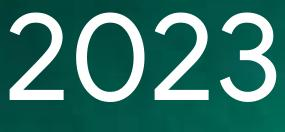

In [14]:
def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

plt_img_base64(img_base64_list[1])

In [15]:
image_summaries[1] # matches index of the image.

'Image features the year "2023" in large white font on a dark green background.'